# Word Embeddings for Sentiment Analysis

This notebook explains an introduction to word embeddings. We will train our own word embeddings using a simple Keras model for a sentiment classification task.

Steps include:
1. Downloading data from tensorflow dataset.
2. Segregating training and testing sentences & labels.
3. Data preparation to padded sequences
4. Defining out Keras model with an Embedding layer.
5. Train the model and explore the weights from the embedding layer.


#### Two very common vectorizing strategies include:

**One-hot enconding** - Creates a very sparse matrix (inefficient).

**Unique number enconding** - It does not capture any relationship between the words (hard to interpret)

Now, **word embeddings** give us a way to use an efficient dense representation in which similar words have a similar encoding. And importantly, you do not have to specify the encoding by hand.

In [3]:
#! pip install tensorflow-datasets

In [4]:
##import the required libraries and APIs
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

2.13.1


### 1. Downloading the TensorFlow `imdb_review` dataset

> Make sure tensorflow_datasets is installed

In [6]:
##load the imdb reviews dataset
data, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

### 2. Segregating training and testing sets

In [8]:
##segregate training and test set
train_data, test_data = data['train'], data['test']

##create empty list to store sentences and labels
train_sentences = []
test_sentences = []

train_labels = []
test_labels = []

In [9]:
# Iterate over the train data to extract sentences and labels
for sent, label in train_data:                               # Loop through each sentence and label pair in the training data
    train_sentences.append(str(sent.numpy().decode('utf8'))) # Convert the sentence tensor to a string, then append to the train_sentences list
    train_labels.append(label.numpy())                       # Convert the label tensor to a NumPy array and append to the train_labels list

# Iterate over the test set to extract sentences and labels
for sent, label in test_data:                                # Loop through each sentence and label pair in the test data
    test_sentences.append(str(sent.numpy().decode('utf8')))  # Convert the sentence tensor to a string, then append to the test_sentences list
    test_labels.append(label.numpy())                        # Convert the label tensor to a NumPy array and append to the test_labels list

In [10]:
##convert lists into numpy array
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

### 3. Data preparation - setting up the tokenizer

In [12]:
##define the parameters for the tokenizing and padding
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

In [13]:
tokenizer = Tokenizer(num_words=vocab_size,                # Initialize the Tokenizer with the vocabulary size and OOV token.
                      oov_token=oov_tok)

tokenizer.fit_on_texts(train_sentences)                    # Fit the tokenizer on the training sentences to build the word index.
word_index = tokenizer.word_index                          # Retrieve the word index mapping words to integers.

## Training sequences and labels
train_seqs = tokenizer.texts_to_sequences(train_sentences) # Convert training sentences to sequences of integer tokens.
train_padded = pad_sequences(                              # Pad the sequences to ensure they all have the same length.
                             train_seqs,                   # Sequences to pad.
                             maxlen=max_length,            # Maximum length of each sequence.
                             truncating=trunc_type         # Truncation type when sequences are longer than max_length.
                            )

## Testing sequences and labels
test_seqs = tokenizer.texts_to_sequences(test_sentences)   # Convert testing sentences to sequences of integer tokens.
test_padded = pad_sequences(                               # Pad the sequences to ensure they all have the same length.
                            test_seqs,                     # Sequences to pad.
                            maxlen=max_length              # Maximum length of each sequence.
                            )

In [14]:
# Create a dictionary to reverse the word index, mapping integers back to words.
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])  

# Define a function to decode sequences of integers back into human-readable text.
def decode_review(text):                                  
    return ' '.join([reverse_word_index.get(i, '?') for i in text])  # Replace each integer with its corresponding word; use '?' if is not found.

print(train_sentences[1])                                  # Print the second training sentence (before tokenization).
print()
print(train_padded[1])                                     # Print the padded sequence of the second training sentence.
print()
print(decode_review(train_padded[1]))                      # Decode the padded sequence back into the original sentence form (or closest match).

I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of what was causing them or why. I admit, I may have missed part of the film, but i watched the majority of it and everything just seemed to happen of its own accord without any real concern for anything else. I cant recommend this film at all.

[   0    0    0    0    0    0    0    0   11   26   75  571    6  805
 2354  313  106   19   12    7  629  686    6    4 2219    5  181  584
   64 1454  110 2263    3 3951   21    2    1    3  258   41 4677    4
  174  188   21   12 4078   11 1578 2354   86    2   20   14 1907    2
  112  940   14 1811 1340  548    3  355  181  466    6  591   19   17
   55 1817    5   49   14 

### 4. Define the Neural Network with Embedding layer

1. Use the Sequential API.
2. Add an embedding input layer of input size equal to vocabulary size.
3. Add a flatten layer, and two dense layers.

In [16]:
model = tf.keras.Sequential([      # Create a Sequential model to stack layers linearly.
    tf.keras.layers.Embedding(     # Add an Embedding layer to convert word indices to dense vectors of fixed size.
        vocab_size,                # Set the vocabulary size as the number of possible word indices.
        embedding_dim,             # Define the dimensionality of the embedding space.
        input_length=max_length    # Specify the length of the input sequences.
    ),
    tf.keras.layers.Flatten(),                       # Flatten the 2D embeddings into a 1D vector for each input sequence.
    tf.keras.layers.Dense(6, activation='relu'),     # Add a Dense layer with 6 units and ReLU activation for learning non-linear features.
    tf.keras.layers.Dense(1, activation='sigmoid')   # Add an output Dense layer with 1 unit and sigmoid activation for binary classification.
])

# Compile the model with loss function, optimizer, and evaluation metric.
model.compile(
    loss='binary_crossentropy',   # Use binary crossentropy as the loss function for binary classification.
    optimizer='adam',             # Use the Adam optimizer for efficient gradient descent.
    metrics=['accuracy']          # Track accuracy as the evaluation metric during training.
)

model.summary()      # Display a summary of the model architecture.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171533 (670.05 KB)
Trainable params: 171533 (670.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 5. Model Training

In [18]:
num_epochs = 10    # Set the number of epochs to train the model.

# Train the model using the training data and validate using the test data.
model.fit(
    train_padded,                                # Use the padded training sequences as input data.
    train_labels,                                # Use the corresponding labels for training.
    epochs=num_epochs,                           # Train the model for the specified number of epochs.
    validation_data=(test_padded, test_labels)   # Use the padded test sequences and labels for validation.
)

Epoch 1/10
782/782 [==============================] - 8s 8ms/step - loss: 0.4867 - accuracy: 0.7484 - val_loss: 0.3463 - val_accuracy: 0.8495
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 0.2349 - accuracy: 0.9104 - val_loss: 0.3909 - val_accuracy: 0.8300
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 0.0827 - accuracy: 0.9799 - val_loss: 0.4495 - val_accuracy: 0.8326
Epoch 4/10
782/782 [==============================] - 6s 8ms/step - loss: 0.0196 - accuracy: 0.9976 - val_loss: 0.5327 - val_accuracy: 0.8272
Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.0047 - accuracy: 0.9999 - val_loss: 0.5849 - val_accuracy: 0.8311
Epoch 6/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.6345 - val_accuracy: 0.8308
Epoch 7/10
782/782 [==============================] - 4s 6ms/step - loss: 8.0726e-04 - accuracy: 1.0000 - val_loss: 0.6755 - val_accuracy: 0.8312
Ep

#### Deriving weights from the embedding layer

In [20]:
# Isolating the first embedding layer from the model.
l1 = model.layers[0]


# Extracting the learned weights (embeddings) from the first layer.

weights = l1.get_weights()[0]  # Retrieve the weights matrix, which holds the embeddings.
print(weights.shape)           # Print the shape of the weights; expected shape: (vocab_size, embedding_dim).
print(weights[0])              # Print the weights for the first token (usually the OOV token).

(10000, 16)
[ 0.06578237  0.01616081 -0.02678456  0.01403826 -0.04105218  0.04631002
 -0.01617832 -0.00771912 -0.0299448  -0.01774015  0.05157409 -0.04446197
 -0.02435921 -0.03786899 -0.04577496 -0.01722278]


# Classifying News Headlines

In [22]:
import pandas as pd

# Download Kaggle Dataset
data = pd.read_json('data/Sarcasm_Headlines_Dataset.json', lines=True)

data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [23]:
# create lists to store the headlines and labels
headlines = list(data['headline'])
labels = list(data['is_sarcastic'])

headlines[:5]  # First 5 lines

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild",
 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
 'j.k. rowling wishes snape happy birthday in the most magical way']

#### Set the Parameters

In [25]:
##define tokenizing and padding parameters
vocab_size = 10000
max_length = 120
embedding_dim = 16
trunc_type='post'
padding_type='post'
oov_tok = ""
training_size = 20000

#### Splitting the training and testing set

In [27]:
##sentences
training_sentences = headlines[0:training_size]  # Extract training sentences from the headlines list, up to the training size.
testing_sentences = headlines[training_size:]    # Extract testing sentences from the headlines list, starting from the training size to the end.

##labels
training_labels = labels[0:training_size]   # Extract training labels from the labels list, up to the training size.
testing_labels = labels[training_size:]     # Extract testing labels from the labels list, starting from the training size to the end.

#### Preprocess sentences

In [29]:
tokenizer = Tokenizer(num_words=vocab_size,  # Initialize the Tokenizer with a vocabulary size limit 
                      oov_token=oov_tok)     # and out-of-vocabulary token.

# Fit the tokenizer on the training sentences to build the word index.
tokenizer.fit_on_texts(training_sentences)  

# Retrieve the word index dictionary, mapping words to their integer indices.
word_index = tokenizer.word_index  

# Convert the training sentences to sequences of integers based on the word index.
training_sequences = tokenizer.texts_to_sequences(training_sentences)  

training_padded = pad_sequences(training_sequences,     # Pad the sequences to ensure uniform length.
                                maxlen=max_length,      # Set the maximum length for padding.
                                padding=padding_type,   # Specify padding type ('pre' or 'post').
                                truncating=trunc_type)  # Specify truncating type ('pre' or 'post').

# Convert the testing sentences to sequences of integers using the same tokenizer.
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)  

testing_padded = pad_sequences(testing_sequences,      # Pad the testing sequences to ensure uniform length.
                               maxlen=max_length,      # Set the maximum length for padding.
                               padding=padding_type,   # Specify padding type ('pre' or 'post').
                               truncating=trunc_type)  # Specify truncating type ('pre' or 'post').

In [30]:
# Convert lists into numpy arrays to ensure compatibility with TensorFlow 2.x

training_padded = np.array(training_padded)  # Convert the padded training sequences to a numpy array.
training_labels = np.array(training_labels)  # Convert the training labels to a numpy array.
testing_padded = np.array(testing_padded)    # Convert the padded testing sequences to a numpy array.
testing_labels = np.array(testing_labels)    # Convert the testing labels to a numpy array.

### Define the neural network model with the following layers:
1. Embedding layer
2. Global Average pooling layer(1D)
3. Dense layer with 24 nodes
4. Output Dense layer with sigmoid activation

In [32]:
model = tf.keras.Sequential([      # Create a Sequential model to stack layers linearly.
    tf.keras.layers.Embedding(     # Add an Embedding layer to convert word indices to dense vectors of fixed size.
        vocab_size,                # Set the vocabulary size as the number of possible word indices.
        embedding_dim,             # Define the dimensionality of the embedding space.
        input_length=max_length    # Specify the length of the input sequences.
    ),
    tf.keras.layers.GlobalAveragePooling1D(),        # Reduces each sequence to a single vector by averaging over time steps.
    tf.keras.layers.Dense(24, activation='relu'),    # Add a Dense layer with 24 units and ReLU activation for learning non-linear features.
    tf.keras.layers.Dense(1, activation='sigmoid')   # Add an output Dense layer with 1 unit and sigmoid activation for binary classification.
])

# Compile the model with loss function, optimizer, and evaluation metric.
model.compile(
    loss='binary_crossentropy',   # Use binary crossentropy as the loss function for binary classification.
    optimizer='adam',             # Use the Adam optimizer for efficient gradient descent.
    metrics=['accuracy']          # Track accuracy as the evaluation metric during training.
)

model.summary()      # Display a summary of the model architecture.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160433 (626.69 KB)
Trainable params: 160433 (626.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Train the model

In [34]:
# Set the number of epochs for training the model.
num_epochs = 30  

# Train the model with training data and validate with testing data.

history = model.fit(training_padded,                                   # Training input sequences.
                    training_labels,                                   # Training labels.
                    epochs=num_epochs,                                 # Number of epochs to train.
                    validation_data=(testing_padded, testing_labels),  # Validation data for evaluating the model during training.
                    verbose=2)                                         # Verbosity mode for logging the training progress.

Epoch 1/30
625/625 - 5s - loss: 0.6744 - accuracy: 0.5706 - val_loss: 0.6204 - val_accuracy: 0.6117 - 5s/epoch - 8ms/step
Epoch 2/30
625/625 - 2s - loss: 0.4501 - accuracy: 0.8131 - val_loss: 0.3918 - val_accuracy: 0.8296 - 2s/epoch - 2ms/step
Epoch 3/30
625/625 - 2s - loss: 0.3135 - accuracy: 0.8733 - val_loss: 0.3604 - val_accuracy: 0.8450 - 2s/epoch - 3ms/step
Epoch 4/30
625/625 - 3s - loss: 0.2609 - accuracy: 0.8983 - val_loss: 0.3496 - val_accuracy: 0.8524 - 3s/epoch - 5ms/step
Epoch 5/30
625/625 - 3s - loss: 0.2255 - accuracy: 0.9135 - val_loss: 0.3439 - val_accuracy: 0.8547 - 3s/epoch - 5ms/step
Epoch 6/30
625/625 - 3s - loss: 0.2005 - accuracy: 0.9217 - val_loss: 0.3553 - val_accuracy: 0.8548 - 3s/epoch - 5ms/step
Epoch 7/30
625/625 - 4s - loss: 0.1759 - accuracy: 0.9333 - val_loss: 0.3622 - val_accuracy: 0.8545 - 4s/epoch - 6ms/step
Epoch 8/30
625/625 - 4s - loss: 0.1578 - accuracy: 0.9420 - val_loss: 0.3778 - val_accuracy: 0.8538 - 4s/epoch - 6ms/step
Epoch 9/30
625/625 - 4s 

#### Visualise the train & validation accuracy and loss

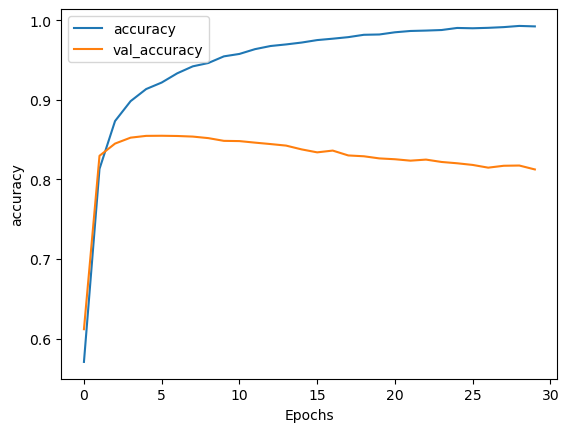

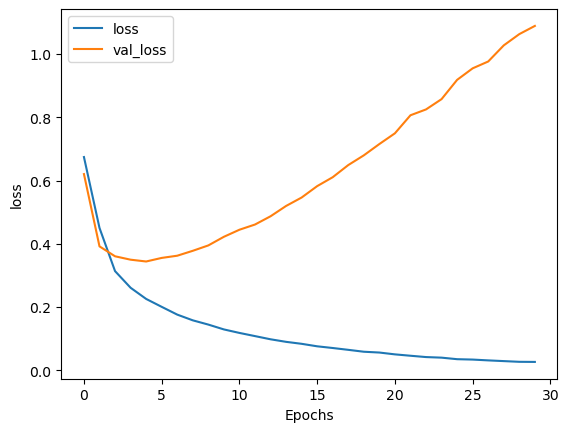

In [36]:
import matplotlib.pyplot as plt

# Define a function to plot graphs for training and validation metrics.
def plot_graphs(history, string):
    plt.plot(history.history[string])         # Plot training metric values.
    plt.plot(history.history['val_'+string])  # Plot validation metric values.
    plt.legend([string, 'val_'+string])       # Add legend to distinguish between training and validation metrics.
    plt.xlabel("Epochs")                      # Label for the x-axis.
    plt.ylabel(string)                        # Label for the y-axis, which is the metric being plotted.
    plt.show()                                # Display the plot.

# Plot accuracy and loss for both training and validation datasets.
plot_graphs(history, "accuracy")  # Plot accuracy over epochs.
plot_graphs(history, "loss")      # Plot loss over epochs.

#### Classifying a new sentence

In [38]:
sentence = ["the baby boy fears spiders in the garden might be real", 
            "game of thrones season finale showing this sunday night"]

# Prepare the sequences of the sentences using the tokenizer.
sequences = tokenizer.texts_to_sequences(sentence)  

# Pad the sequences to ensure they have the same length as the input length used during training.
padded_seqs = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Predict the class probabilities for the padded sequences using the trained model.
print(model.predict(padded_seqs))

1/1 [==============================] - 0s 152ms/step
[[8.7117602e-04]
 [5.0921217e-06]]


*Here we see both of these are very close to zero, both of these do not contain any sarcasm. And that's how this model is actually classifying headlines based on if that particular sentence or if that particular headline is sarcastic or not.* 

# Text Classification Challenge

#### Download the data

In [42]:
##load the imdb reviews dataset
data, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

#### Segregating training and testing sets

In [44]:
##segregate training and test set
train_data, test_data = data['train'], data['test']

##create empty list to store sentences and labels
train_sentences = []
test_sentences = []

train_labels = []
test_labels = []

In [45]:
##iterate over the train data to extract sentences and labels
for sent, label in train_data:
    train_sentences.append(str(sent.numpy().decode('utf8')))
    train_labels.append(label.numpy())

##iterate over the test set to extract sentences and labels
for sent, label in test_data:
    test_sentences.append(str(sent.numpy().decode('utf8')))
    test_labels.append(label.numpy())

In [46]:
##convert lists into numpy array
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

#### Data preparation - setting up the tokenizer

In [48]:
##define the parameters for the tokenizing and padding
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = ""

In [49]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

##training sequences and labels
train_seqs = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_seqs, maxlen=max_length, truncating=trunc_type)

##testing sequences and labels
test_seqs = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_seqs,maxlen=max_length)

### Define the Neural Network with Embedding layer
1. Use the Sequential API.
2. Add an embedding input layer of input size equal to vocabulary size.
3. Add a flatten layer, and two dense layers.

In [51]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

##compile the model with loss function, optimizer and metrics
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_4 (Dense)             (None, 24)                408       
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160433 (626.69 KB)
Trainable params: 160433 (626.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Model Training

In [53]:
num_epochs = 10

# Train the model 
history = model.fit(
    train_padded,        # Training sequences
    train_labels,        # Training labels
    epochs=num_epochs,   # Number of epochs for training
    validation_data=(test_padded, test_labels)  # Validation data to evaluate the model's performance
    )

Epoch 1/10
782/782 [==============================] - 7s 8ms/step - loss: 0.5004 - accuracy: 0.7728 - val_loss: 0.3461 - val_accuracy: 0.8542
Epoch 2/10
782/782 [==============================] - 5s 6ms/step - loss: 0.3019 - accuracy: 0.8742 - val_loss: 0.3450 - val_accuracy: 0.8497
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 0.2471 - accuracy: 0.9026 - val_loss: 0.3422 - val_accuracy: 0.8546
Epoch 4/10
782/782 [==============================] - 7s 9ms/step - loss: 0.2137 - accuracy: 0.9194 - val_loss: 0.3750 - val_accuracy: 0.8442
Epoch 5/10
782/782 [==============================] - 2s 3ms/step - loss: 0.1870 - accuracy: 0.9316 - val_loss: 0.4072 - val_accuracy: 0.8390
Epoch 6/10
782/782 [==============================] - 5s 6ms/step - loss: 0.1670 - accuracy: 0.9411 - val_loss: 0.4431 - val_accuracy: 0.8338
Epoch 7/10
782/782 [==============================] - 6s 8ms/step - loss: 0.1482 - accuracy: 0.9491 - val_loss: 0.5109 - val_accuracy: 0.8182
Epoch 

The training accuracy is 0.97% and the validation accuracy is 81.6%.

#### Visualise the train & validation accuracy and loss

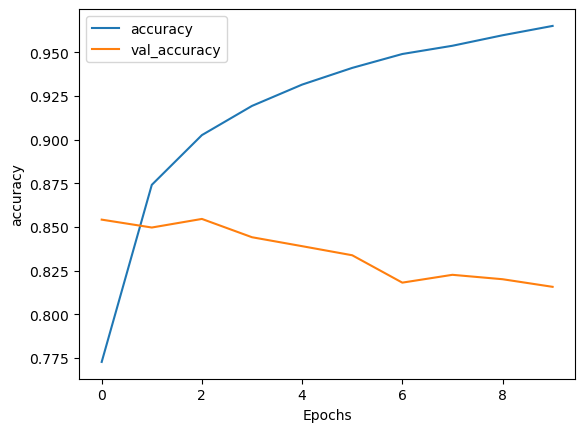

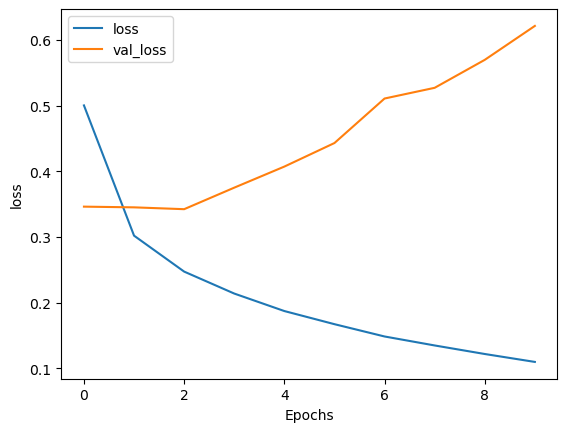

In [55]:
import matplotlib.pyplot as plt

##plot the scores from history
def plot_metrics(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.legend([metric, 'val_'+metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.show()
  
##plot accuracy
plot_metrics(history, "accuracy")

##plot loss
plot_metrics(history, "loss")

You can see there's slightly a gap between the training accuracy and the validation to the model is doing a decent job but it's a little offering as well.

#### Classify new reviews

In [57]:
sentence = ["The first part of the movie was dull and boring!", 
            "We watched Queen's Gambit, all seven hours of it, in a single sitting. This show is an absolute gem."]

##prepare the sequences of the sentences in question
sequences = tokenizer.texts_to_sequences(sentence)
padded_seqs = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

##print the classification score
print(model.predict(padded_seqs))

1/1 [==============================] - 0s 88ms/step
[[0.232574  ]
 [0.87524426]]


The first line received a classification close to zero, which means it is a negative review. 

The second line received a classification close to 1, wich means it is a positive review.